In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
import sklearn.model_selection as skm 
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#ramki danych do licencjata
import os

folder_path = "C:/Users/Nitro/Desktop/rzeczy na studia/licencjat/zbiorydanychLIC"

csv_data_list = []

#zgranie wszystkich plików csv z folderu do listy
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        csv_data_list.append(pd.read_csv(file_path))

In [3]:
#zmiana nazwy kolumny class na Class
for idx, i in enumerate(csv_data_list):
    if "class" in i.columns:
        csv_data_list[idx] = i.rename(columns={"class": "Class"})
#rozbicie listy na macierz, gdzie każdy wiersz to zbiór danych a kolumny to metoda preprocessingu
M = [[] for _ in range(1,11)]
k = 0
for j in range(len(M)):
    for i in range(1,36):
        M[j].append(csv_data_list[k])
        k += 1 

**Modele, najpierw RandomSearch potem Default**

*RandomSearch*

In [ ]:
#kroswalidacja i randomsearch
wynikitrain = [[] for _ in range(1,11)]
wynikitest = [[] for _ in range(1,11)]
for i in range(len(M)):
    for j in range(len(M[0])):
        M[i][j] = pd.get_dummies(M[i][j], dtype = 'int64')
        X = M[i][j].drop('Class', axis=1)
        y = M[i][j].Class
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 420)
        model = ExtraTreesClassifier(random_state=420)
        kfold = skm.KFold(5, shuffle=True)
        wynikitrain[i].append(round(cross_val_score(model, X_train, y_train, cv = kfold, scoring = "roc_auc").mean(), 3))
        randsearch = skm.RandomizedSearchCV(model,
                                            {'n_estimators': [100, 200, 300, 400, 500],
                                            'max_depth': [None, 20, 40, 60, 80, 100],
                                            'min_samples_split': [2, 5, 10],
                                            'max_features': ['sqrt', 'log2'],
                                            'criterion': ['gini', 'entropy'],},
                                            n_iter = 20,
                                            scoring = 'roc_auc',
                                            cv = kfold)
        model = randsearch.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        wynikitest[i].append(round(roc_auc, 3))

In [ ]:
#poprzednia komórka liczyła się 272 minuty XD

In [10]:
wynikitrain = np.array(wynikitrain)
wynikitest = np.array(wynikitest)
print("wyniki trening:", "\n")
print(wynikitrain)
print("wyniki test:", "\n")
print(wynikitest)

wyniki trening: 

[[0.998 0.997 0.998 0.999 0.998 0.998 0.999 0.998 0.998 0.998 0.997 0.995
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.636 0.672 0.664 0.662 0.676 0.642 0.652 0.668 0.634 0.662 0.695 0.686
  0.663 0.655 0.667 0.654 0.684 0.652 0.662 0.653 0.65  0.662 0.646 0.671
  0.659 0.68  0.666 0.668 0.676 0.648 0.64  0.677 0.647 0.673 0.647]
 [0.991 0.99  0.992 0.992 0.992 0.992 0.991 0.993 0.992 0.992 0.993 0.993
  0.992 0.992 0.99  0.995 0.991 0.991 0.991 0.992 0.994 0.993 0.99  0.994
  0.993 0.993 0.99  0.994 0.995 0.993 0.992 0.995 0.991 0.994 0.994]
 [0.912 0.912 0.916 0.908 0.915 0.917 0.911 0.916 0.907 0.914 0.916 0.922
  0.908 0.928 0.913 0.914 0.922 0.909 0.91  0.917 0.904 0.908 0.91  0.922
  0.908 0.92  0.901 0.904 0.901 0.918 0.916 0.908 0.913 0.921 0.905]
 [0.774 0.756 0.792 0.749 0.699 0.778 0.772 0.778 0.7   0.762 0.747 0.751
  0.774 0.757 0.787 0.758 0.722 0.778 0.787

In [11]:
meanformethodtest = []
for i in range(len(M[0])):
    l = []
    for j in range(0,10):
        l.append(wynikitest[j][i])
    meanformethodtest.append(round(np.mean(l),3))
print("średnie wyniki dla danych metod: \n", meanformethodtest)
print("najlepszy średni wynik: \n", max(meanformethodtest))
print("metoda z najlepszym wynikiem: \n", meanformethodtest.index(max(meanformethodtest)))
print("odchylenie standardowe średnich wyników różnych metod: \n", np.std(meanformethodtest))

średnie wyniki dla danych metod: 
 [0.892, 0.892, 0.893, 0.889, 0.892, 0.89, 0.888, 0.891, 0.886, 0.891, 0.887, 0.89, 0.891, 0.89, 0.894, 0.89, 0.888, 0.888, 0.892, 0.891, 0.886, 0.891, 0.89, 0.89, 0.89, 0.885, 0.888, 0.89, 0.89, 0.89, 0.888, 0.885, 0.888, 0.886, 0.888]
najlepszy średni wynik: 
 0.894
metoda z najlepszym wynikiem: 
 14
odchylenie standardowe średnich wyników różnych metod: 
 0.002207593573952214


In [12]:
wynikitest = pd.DataFrame(wynikitest)

In [13]:
#zapisanie wyników do pliku csv
wynikitest.to_csv("wyniki.csv", index = False)

*Default*

In [22]:
wynikitrainmodel = [[] for _ in range(1,11)]
wynikitestmodel = [[] for _ in range(1,11)]
for i in range(len(M)):
    for j in range(len(M[0])):
        M[i][j] = pd.get_dummies(M[i][j], dtype = 'int64')
        X = M[i][j].drop('Class', axis=1)
        y = M[i][j].Class
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 420)
        model = ExtraTreesClassifier(random_state=420)
        kfold = skm.KFold(5, shuffle=True)
        wynikitrainmodel[i].append(round(cross_val_score(model, X_train, y_train, cv = kfold, scoring = "roc_auc").mean(), 3))
        model = model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        wynikitestmodel[i].append(round(roc_auc, 3))

In [23]:
wynikitrainmodel = np.array(wynikitrainmodel)
wynikitestmodel = np.array(wynikitestmodel)
print("wyniki trening:", "\n")
print(wynikitrainmodel)
print("wyniki test:", "\n")
print(wynikitestmodel)

wyniki trening: 

[[0.998 0.999 0.998 0.999 0.998 0.998 0.999 0.996 0.997 0.997 0.997 0.998
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.668 0.666 0.676 0.666 0.704 0.682 0.665 0.681 0.68  0.702 0.711 0.703
  0.674 0.672 0.672 0.65  0.669 0.651 0.672 0.656 0.643 0.64  0.666 0.703
  0.668 0.652 0.687 0.671 0.669 0.659 0.673 0.657 0.66  0.668 0.668]
 [0.993 0.993 0.992 0.992 0.992 0.99  0.993 0.993 0.991 0.991 0.991 0.992
  0.994 0.994 0.991 0.992 0.994 0.992 0.994 0.991 0.993 0.991 0.992 0.994
  0.994 0.994 0.995 0.994 0.994 0.991 0.993 0.99  0.993 0.994 0.993]
 [0.915 0.912 0.904 0.914 0.918 0.914 0.908 0.911 0.909 0.897 0.908 0.913
  0.911 0.913 0.914 0.911 0.921 0.914 0.909 0.908 0.91  0.911 0.902 0.903
  0.912 0.928 0.913 0.906 0.91  0.905 0.91  0.906 0.919 0.907 0.911]
 [0.779 0.752 0.796 0.751 0.706 0.751 0.754 0.774 0.699 0.773 0.779 0.785
  0.77  0.764 0.793 0.731 0.72  0.773 0.776

In [24]:
meanformethodtestmodel = []
for i in range(len(M[0])):
    l = []
    for j in range(0,10):
        l.append(wynikitestmodel[j][i])
    meanformethodtestmodel.append(round(np.mean(l),3))
print("średnie wyniki dla danych metod: \n", meanformethodtestmodel)
print("najlepszy średni wynik: \n", max(meanformethodtestmodel))
print("metoda z najlepszym wynikiem: \n", meanformethodtestmodel.index(max(meanformethodtestmodel)))
print("odchylenie standardowe średnich wyników różnych metod: \n", np.std(meanformethodtestmodel))

średnie wyniki dla danych metod: 
 [0.872, 0.867, 0.875, 0.869, 0.866, 0.87, 0.87, 0.871, 0.862, 0.871, 0.864, 0.871, 0.871, 0.86, 0.872, 0.87, 0.865, 0.868, 0.871, 0.871, 0.862, 0.871, 0.871, 0.863, 0.871, 0.861, 0.867, 0.869, 0.869, 0.865, 0.869, 0.861, 0.872, 0.861, 0.869]
najlepszy średni wynik: 
 0.875
metoda z najlepszym wynikiem: 
 2
odchylenie standardowe średnich wyników różnych metod: 
 0.003937885063776015


In [25]:
wynikitestmodel = pd.DataFrame(wynikitestmodel)

In [26]:
#zapisanie wyników do pliku csv 
wynikitestmodel.to_csv("wyniki_model.csv", index = False)

**Wizualizacja**

*Boxplot zbiorczy: x = metoda, y = ROCAUC z metody*

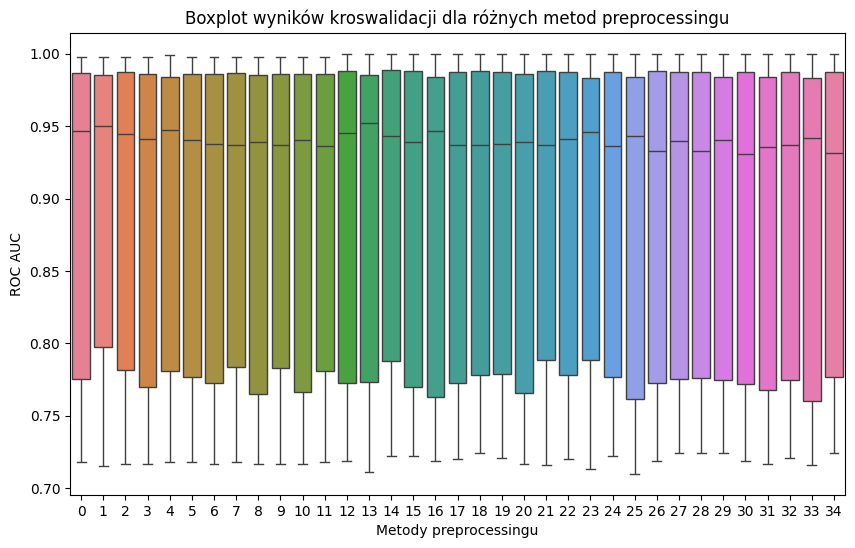

In [14]:
#RadnomizedSearchCV
plt.figure(figsize=(10, 6))
sns.boxplot(data=wynikitest)
plt.title("Boxplot wyników kroswalidacji dla różnych metod preprocessingu")
plt.xlabel("Metody preprocessingu")
plt.ylabel("ROC AUC")
plt.show()

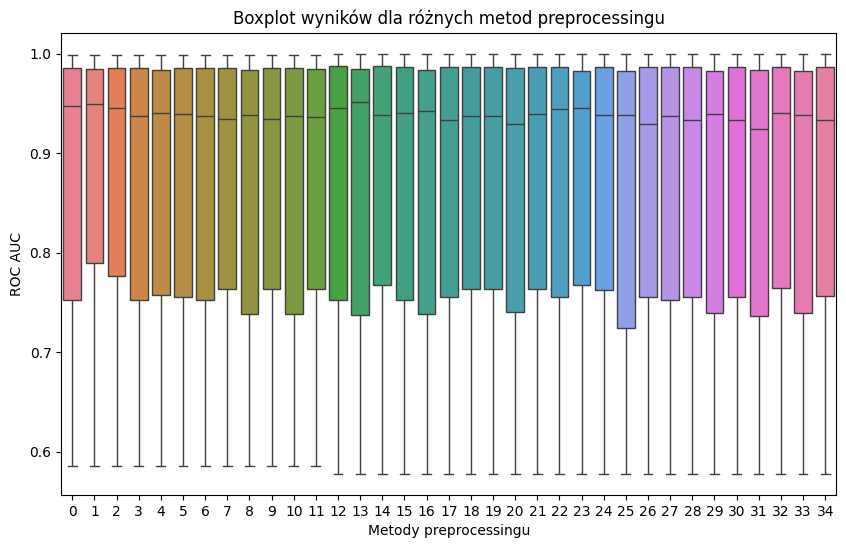

In [27]:
#default
plt.figure(figsize=(10, 6))
sns.boxplot(data=wynikitestmodel)
plt.title("Boxplot wyników dla różnych metod preprocessingu")
plt.xlabel("Metody preprocessingu")
plt.ylabel("ROC AUC")
plt.show()

*Boxplot zbiorczy: x = zbiór, y = ROCAUC*

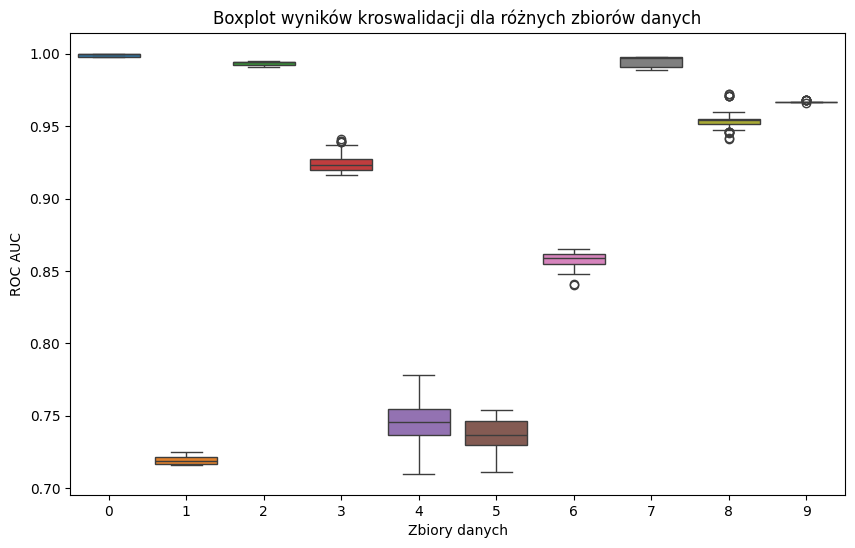

In [15]:
#RandomizedSearchCV
plt.figure(figsize=(10, 6))
sns.boxplot(data=wynikitest.T)
plt.title("Boxplot wyników kroswalidacji dla różnych zbiorów danych")
plt.xlabel("Zbiory danych")
plt.ylabel("ROC AUC")
plt.show()

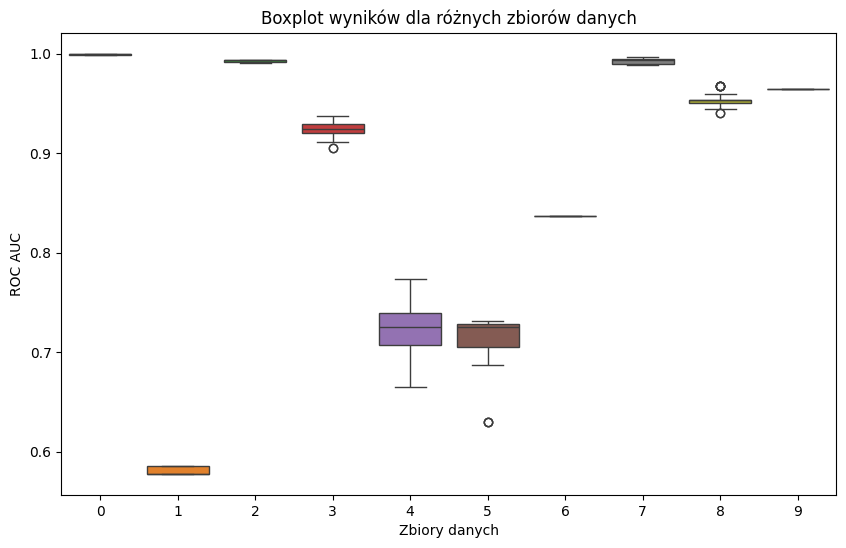

In [28]:
#default
plt.figure(figsize=(10, 6))
sns.boxplot(data=wynikitestmodel.T)
plt.title("Boxplot wyników dla różnych zbiorów danych")
plt.xlabel("Zbiory danych")
plt.ylabel("ROC AUC")
plt.show()

*Wykresy ROCAUC dla każdego zbioru danych, x = metoda, y = ROCAUC, wykres = zbiór danych* 

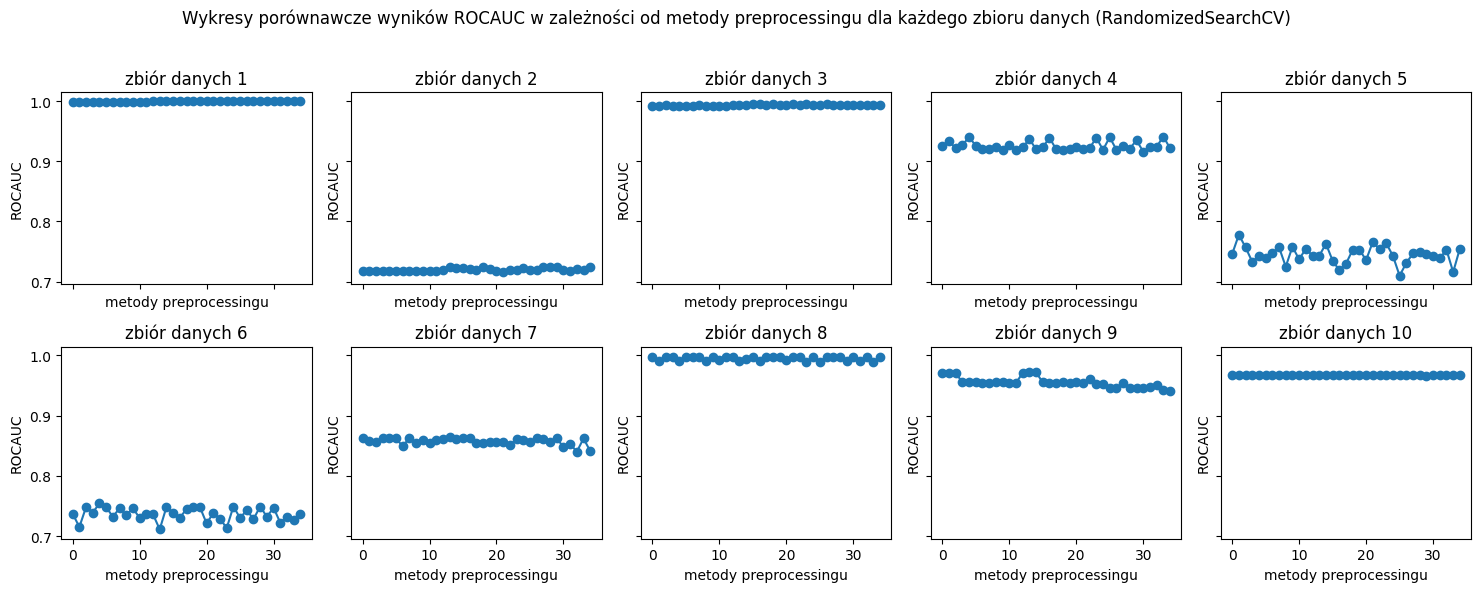

In [61]:
#RandomizedSearchCV 
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
fig.suptitle("Wykresy porównawcze wyników ROCAUC w zależności od metody preprocessingu dla każdego zbioru danych (RandomizedSearchCV)")

for i, ax in enumerate(axes.flat):
    ax.plot(range(35), wynikitest.T[i], marker='o', linestyle='-')
    ax.set_title(f'zbiór danych {i+1}')
    ax.set_xlabel("metody preprocessingu")
    ax.set_ylabel("ROCAUC")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

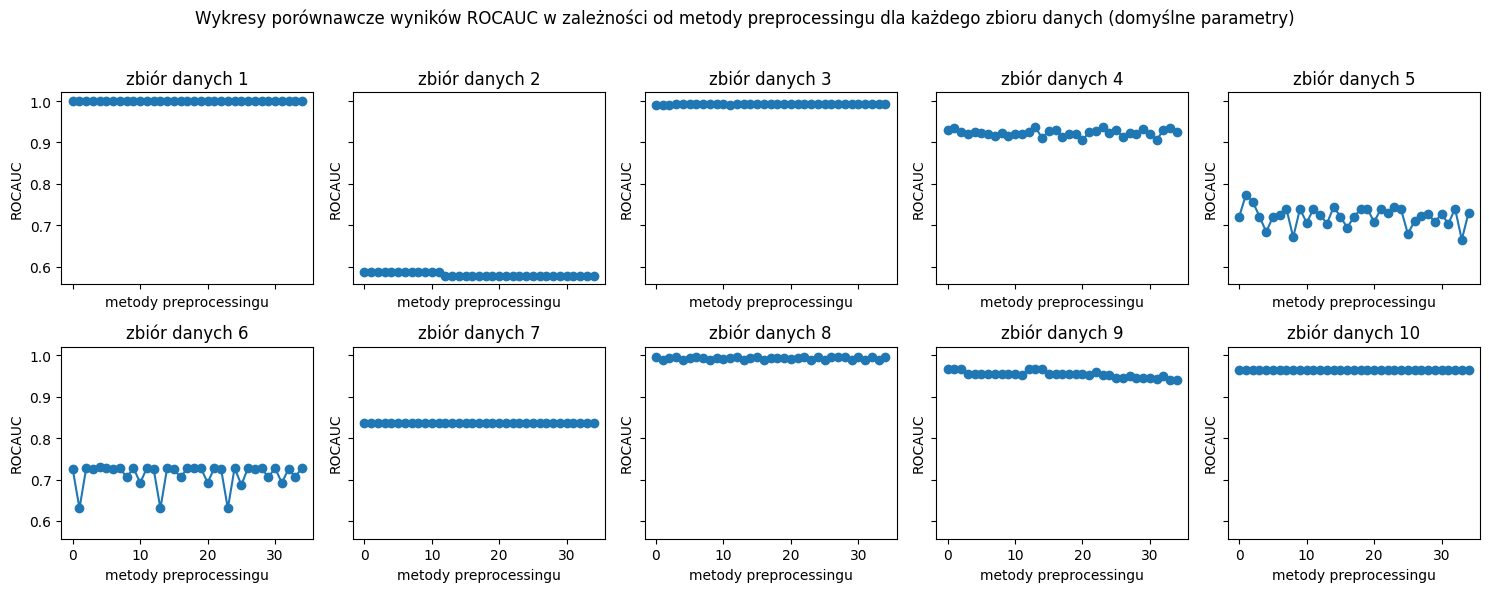

In [62]:
#default
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
fig.suptitle("Wykresy porównawcze wyników ROCAUC w zależności od metody preprocessingu dla każdego zbioru danych (domyślne parametry)")

for i, ax in enumerate(axes.flat):
    ax.plot(range(35), wynikitestmodel.T[i], marker='o', linestyle='-')
    ax.set_title(f'zbiór danych {i+1}')
    ax.set_xlabel("metody preprocessingu")
    ax.set_ylabel("ROCAUC")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

*Boxploty RS vs D  dla każdego zbioru, x = zbiór (RS vs D), y = ROCAUC*

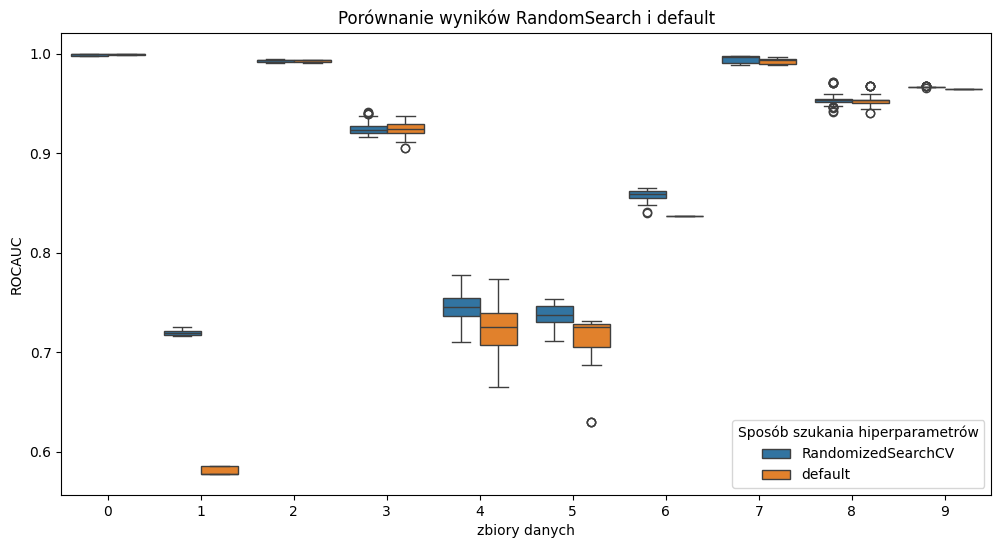

In [ ]:
#Przygotowanie danych do boxplotu porównującego wyniki RandomSearch i default
df1_melted = wynikitest.melt(ignore_index=False).reset_index()
df1_melted.columns = ["zbiór", "metoda preprocessingu", "ROCAUC"]
df1_melted["Macierz"] = "RandomizedSearchCV"

df2_melted = wynikitestmodel.melt(ignore_index=False).reset_index()
df2_melted.columns = ["zbiór", "metoda preprocessingu", "ROCAUC"]
df2_melted["Macierz"] = "default"

df_combined = pd.concat([df1_melted, df2_melted])

# Tworzenie boxplotu porównującego wartości wierszy
plt.figure(figsize=(12, 6))
sns.boxplot(x="zbiór", y="ROCAUC", hue="Macierz", data=df_combined)
plt.xlabel("zbiory danych")
plt.ylabel("ROCAUC")
plt.title("Porównanie wyników RandomSearch i default")
plt.legend(title="Sposób szukania hiperparametrów")
plt.show()


*Heatmapy x = zbiór danych, y = metoda, kolor = max(ROCAUC)*

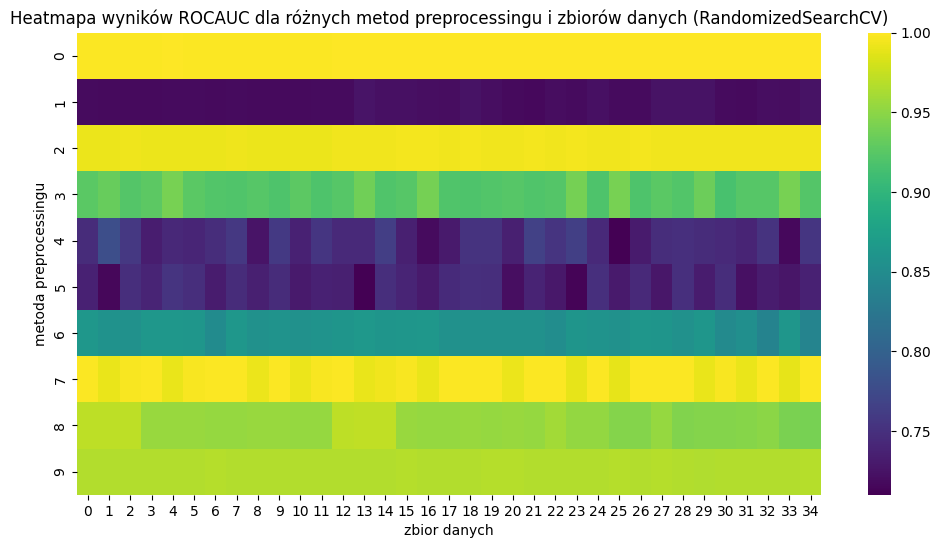

In [46]:
#Heatmapa dla RandomizedSearchCV
plt.figure(figsize=(12, 6)) 
sns.heatmap(wynikitest, cmap="viridis", annot=False, cbar=True) #można zmienić kolor
plt.xlabel("zbior danych")
plt.ylabel("metoda preprocessingu")
plt.title("Heatmapa wyników ROCAUC dla różnych metod preprocessingu i zbiorów danych (RandomizedSearchCV)")
plt.show()

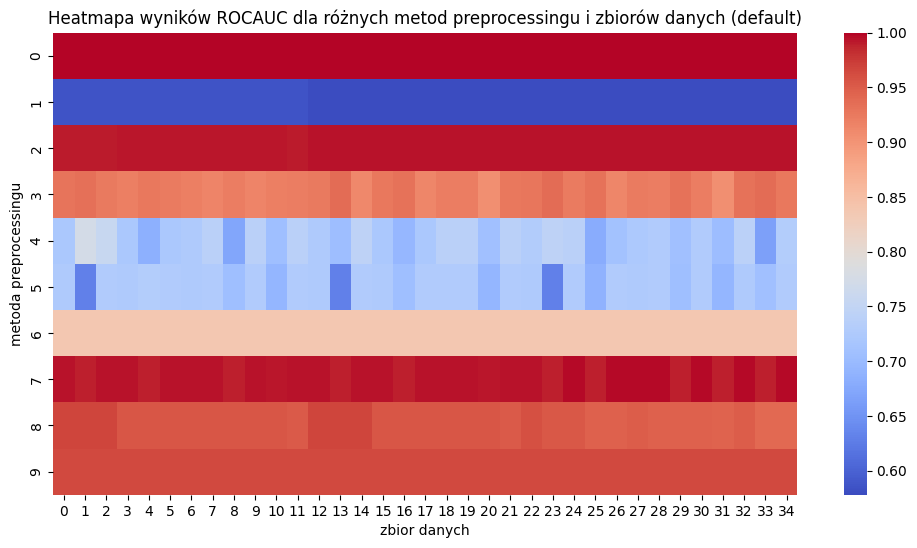

In [49]:
#Heatmapa dla default
plt.figure(figsize=(12, 6))  
sns.heatmap(wynikitestmodel, cmap="coolwarm", annot=False, cbar=True) #można zmienić kolor 
plt.xlabel("zbior danych")
plt.ylabel("metoda preprocessingu")
plt.title("Heatmapa wyników ROCAUC dla różnych metod preprocessingu i zbiorów danych (default)")
plt.show()

Nie wiem jaką paletę najlepiej ustawić dla tych heatmap.